Before I proceed with the assignment I uploaded the dataset I got from Kraggle of which I will share the link in the later part of the assignment and will also be on my readme in github. Then imported the necessary tools that will be needed into Colab for a smooth work done(Load and inspect data)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/content/rentals.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   borough  80 non-null     object 
 1   bezirk   80 non-null     object 
 2   minRent  80 non-null     float64
 3   avgRent  80 non-null     float64
 4   maxRent  80 non-null     float64
 5   minBuy   80 non-null     int64  
 6   avgBuy   80 non-null     int64  
 7   maxBuy   80 non-null     int64  
 8   url      80 non-null     object 
dtypes: float64(3), int64(3), object(3)
memory usage: 5.8+ KB


This stage I performed a basic cleaning

In [2]:
# Drop URL column (not useful for modeling)
df = df.drop(columns=["url"])

# Check missing values
df.isnull().sum()


,0
borough,0
bezirk,0
minRent,0
avgRent,0
maxRent,0
minBuy,0
avgBuy,0
maxBuy,0


Then I perfomed a feature engineering here to test transformations and see the effects on the model performance

In [3]:
df["rent_range"] = df["maxRent"] - df["minRent"]


After feature engineering, I had to perform EDA here by getting the distribution of the average rent

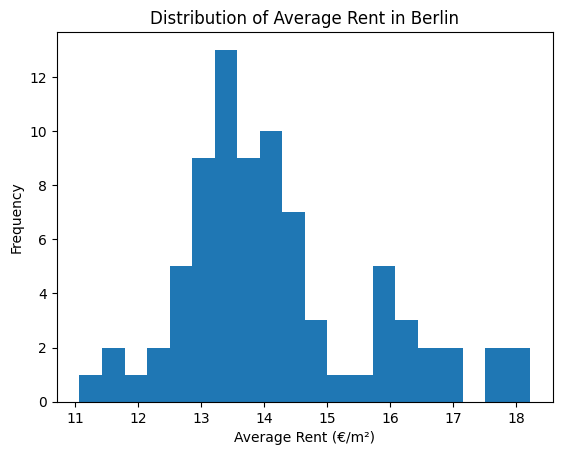

In [4]:
plt.hist(df["avgRent"], bins=20)
plt.xlabel("Average Rent (€/m²)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Rent in Berlin")
plt.show()


This stage shows the Average rent in Berlin

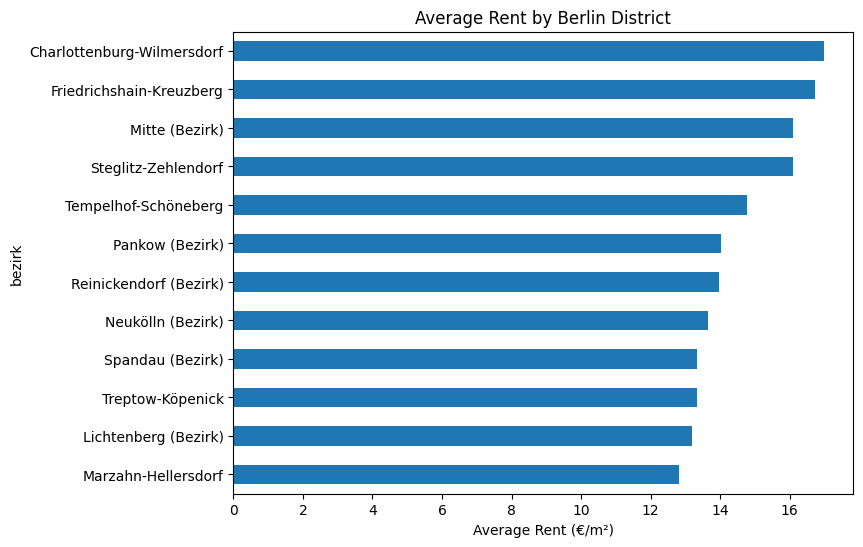

In [5]:
avg_by_bezirk = df.groupby("bezirk")["avgRent"].mean().sort_values()

avg_by_bezirk.plot(kind="barh", figsize=(8,6))
plt.xlabel("Average Rent (€/m²)")
plt.title("Average Rent by Berlin District")
plt.show()


The plot below also portrays the Min Rent vs Average rent

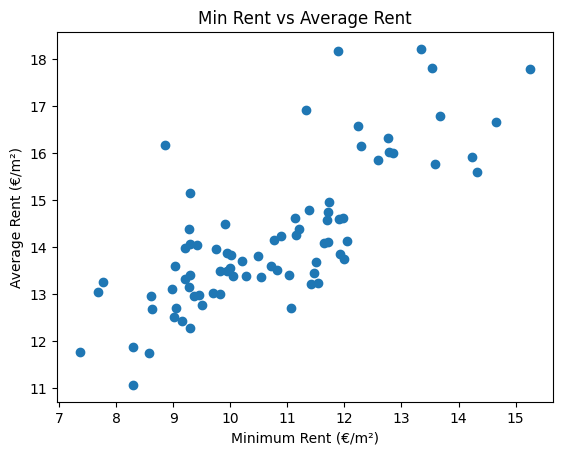

In [6]:
plt.scatter(df["minRent"], df["avgRent"])
plt.xlabel("Minimum Rent (€/m²)")
plt.ylabel("Average Rent (€/m²)")
plt.title("Min Rent vs Average Rent")
plt.show()


The next stage was to check the Max Rent vs Average Rent

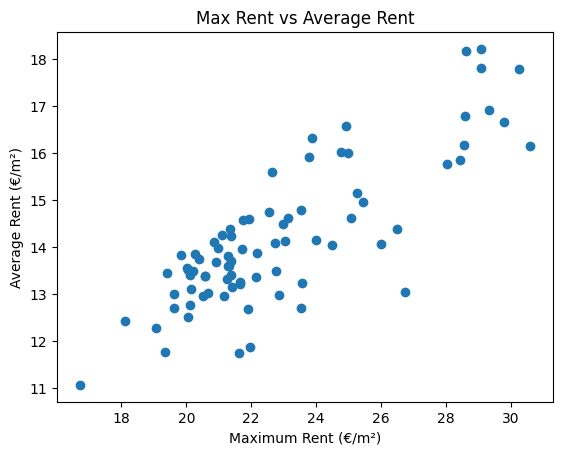

In [7]:
plt.scatter(df["maxRent"], df["avgRent"])
plt.xlabel("Maximum Rent (€/m²)")
plt.ylabel("Average Rent (€/m²)")
plt.title("Max Rent vs Average Rent")
plt.show()


Encoding Categorical Feature

In [8]:
df_encoded = pd.get_dummies(df, columns=["bezirk"], drop_first=True)


This stage is Train-test split

In [9]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("avgRent", axis=1)
y = df_encoded["avgRent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Now model evaluation by Linear regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Drop the 'borough' column from X_train and X_test as it contains string values
# which cause the ValueError
if 'borough' in X_train.columns:
    X_train = X_train.drop('borough', axis=1)
if 'borough' in X_test.columns:
    X_test = X_test.drop('borough', axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(mae, rmse, r2)

0.445937089804725 0.5872596358457254 0.8008070956548348


Random Forest regression

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(
    mean_absolute_error(y_test, y_pred_rf),
    np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    r2_score(y_test, y_pred_rf)
)


0.40578749999999764 0.5164695876815952 0.8459353267128027


Feature importanve

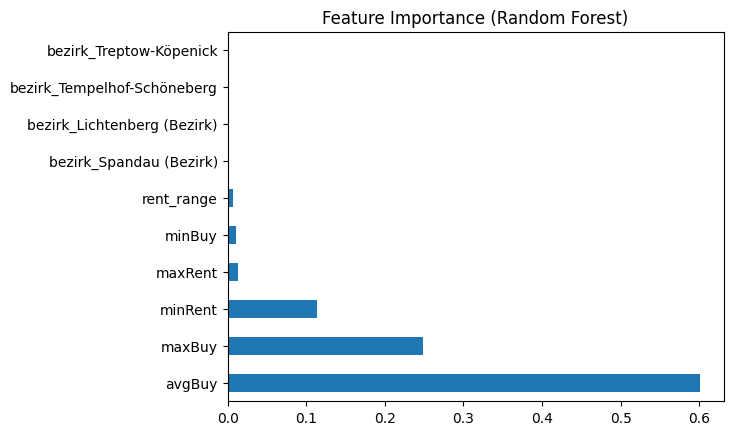

In [12]:
importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.head(10).plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.show()

Gradient Boosting regression, which often perfoms the tabular data

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
gbr_r2 = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Results:")
print("MAE:", gbr_mae)
print("RMSE:", gbr_rmse)
print("R2:", gbr_r2)


Gradient Boosting Results:
MAE: 0.37890357999655944
RMSE: 0.4871681380820797
R2: 0.8629208779173204


Created a final model comparison Table, for quality evidence

In [14]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE": [mae,
            mean_absolute_error(y_test, y_pred_rf),
            gbr_mae],
    "RMSE": [rmse,
             np.sqrt(mean_squared_error(y_test, y_pred_rf)),
             gbr_rmse],
    "R2": [r2,
           r2_score(y_test, y_pred_rf),
           gbr_r2]
})

results


,Model,MAE,RMSE,R2
0,Linear Regression,0.445937,0.587260,0.800807
1,Random Forest,0.405787,0.516470,0.845935
2,Gradient Boosting,0.378904,0.487168,0.862921


Saved the results

In [15]:
import os

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

results.to_csv("results/metrics.csv", index=False)

Residual analysis to understand the model behavior

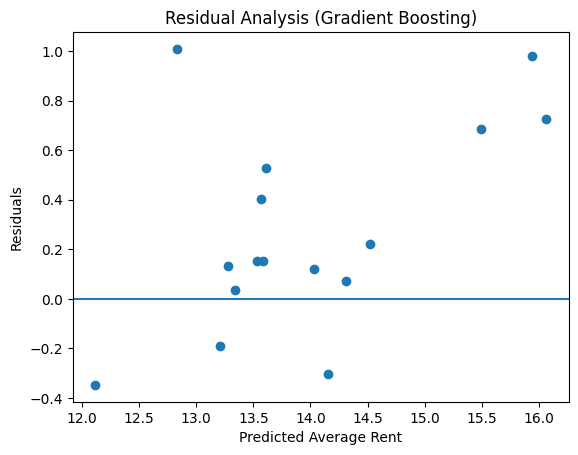

In [16]:
residuals = y_test - y_pred_gbr

plt.scatter(y_pred_gbr, residuals)
plt.axhline(0)
plt.xlabel("Predicted Average Rent")
plt.ylabel("Residuals")
plt.title("Residual Analysis (Gradient Boosting)")
plt.show()


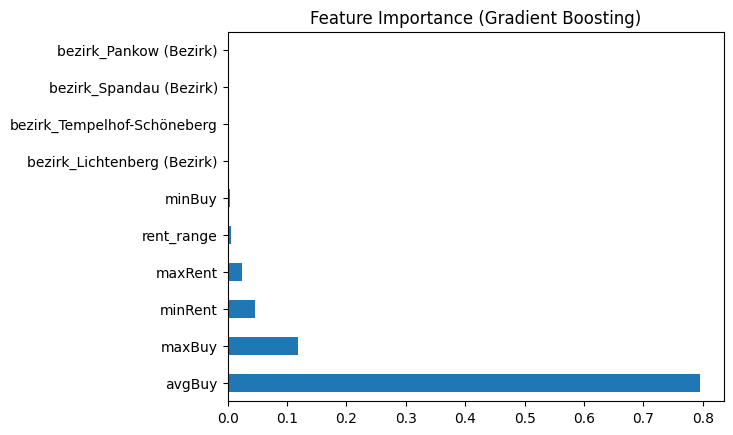

In [17]:
gbr_importances = pd.Series(
    gbr.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

gbr_importances.head(10).plot(kind="barh")
plt.title("Feature Importance (Gradient Boosting)")
plt.show()

Final checks to ensure no overfitting

In [18]:
train_score = gbr.score(X_train, y_train)
test_score = gbr.score(X_test, y_test)

print("Train R2:", train_score)
print("Test R2:", test_score)


Train R2: 0.9994738540290338
Test R2: 0.8629208779173204


Among the evaluated models, Gradient Boosting achieved the lowest prediction error and highest R² score, indicating superior performance in capturing non-linear relationships within aggregated rental price data.

In limitations, “The use of aggregated neighborhood level data limits individual-level price prediction and may obscure intra-district variability